In [5]:
# Clear workspace
%reset
import sys
sys.path.append("/Users/jason.wang/Desktop/hif2gene/scripts/helper_functions/") # replace path

# custom modules
import cluster_features_combine_p_values as cf
import hypothesis_testing as ht

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
from scipy.stats import sem, percentileofscore
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

base_dir = "~/Desktop/hif2gene"
model_output_dir = "/Users/jason.wang/Desktop/hif2gene/data/model_outputs/tigit" # change path


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [6]:
seed = 360
np.random.seed(seed)
outcome = 'TIGIT'

In [7]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(base_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters

Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


## Load in Null Distributions

AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE
[-0.027325928908667543, -0.026792451751868302, -0.02320929522362949, -0.020532123550852655, -0.0175729914086053, -0.015992476350866026, -0.01589368246905172, -0.015470100997268815, -0.014983570071677728, -0.014739797935566274, -0.01420598493605847, -0.0141302299630375, -0.013983264538976685, -0.013582015800404157, -0.013366476479808579, -0.012941900913110713, -0.012470293281027356, -0.012125855153630365, -0.011848878557654688, -0.011466666021080749, -0.01144906053078743, -0.011410296308731624, -0.010980510916638181, -0.009692860083077192, -0.009684239972761953, -0.009656948768662089, -0.009307711265054329, -0.00906862336637944, -0.008588753105614154, -0.008536163897081506, -0.008440616337971425, -0.008138994652762297, -0.007933799133148864, -0.007770275362922063, -0.007632793166975711, -0.007584282079330068, -0.00747706590318335, -0.007382601042684297, -0.007153797168616656, -0.007053650311708147, -0.007038379226035611, -0.006910996013821921, -

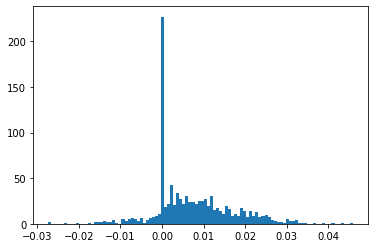

19.9
100.0


In [9]:
hif_null_distributions = pkl.load(open("{0}/hif_beta_null_distributions.pkl".format(model_output_dir), "rb"))
for k, v in hif_null_distributions.items():
    print(k)
    print(sorted(v))
    plt.hist(v, bins=100)
    plt.show()
    print(percentileofscore(v, 0))
    print(percentileofscore(v, 0.1))
    break

## Load in HIF Betas

In [10]:
betas_df = pd.read_csv("{0}/coefficients/pancancer/{1}_model_ensemble.csv".format(model_output_dir, outcome))
betas_df = betas_df[['HIF', 'Beta', 'Cluster']]

# Remove zeros
betas_df = betas_df[betas_df['Beta'] != 0.0]
betas_df


,HIF,Beta,Cluster
28,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN EPITHELIAL_HE,-0.004268,1
30,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN STROMA_HE,-0.001758,1
31,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN TUMOR_HE,-0.000432,1
34,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN STROMA_HE,-0.009405,1
35,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN TUMOR_HE,-0.009250,1
42,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF MACROPHAGE IN STROMA_HE,-0.016605,1
44,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN EPITHELIAL_HE,-0.004239,1
57,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.130899,10
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.314291,10
59,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN TUMOR_HE,0.213766,10


## Compute P-Values

In [6]:
# One-sided
p_values = []
for index, row in betas_df.iterrows():
    hif = row['HIF']
    beta = row['Beta']
    null_distribution = hif_null_distributions[hif]
    
    if (beta > 0):
        percentile = percentileofscore(null_distribution, beta)
        if (percentile == 100.0):
            percentile -= 0.1 # precision to 1/10th of a percentage point
        p_value = (100.0 - percentile)/100.0
        p_values.append(p_value)
    elif (beta < 0):
        percentile = percentileofscore(null_distribution, beta)
        if (percentile == 0.0):
            percentile += 0.1
        p_value = percentile/100.0
        p_values.append(p_value)
    
    print(beta, p_value)

-0.0042681126533581255 0.055999999999999994
-0.001757762922575133 0.114
-0.00043195269401169375 0.128
-0.009405256273492743 0.045
-0.009250058592629541 0.038
-0.016604579149442508 0.005
-0.00423868724403645 0.065
0.13089873835707935 0.0009999999999999432
0.3142910904575543 0.0009999999999999432
0.2137658643015471 0.0009999999999999432
0.3347247965645681 0.0009999999999999432
0.0033026992409337114 0.613
0.013691449360867554 0.42100000000000004
0.6436276013939883 0.0009999999999999432
0.2204178607395613 0.0009999999999999432
0.0870929302802282 0.0009999999999999432
0.01949395347437309 0.27
-0.011195546467967284 0.016
-0.00255317536640372 0.035
-0.001109096190137099 0.048
0.01818889275787464 0.31
0.32640383821364755 0.0009999999999999432
0.00017995478756013402 0.6859999999999999
0.024314048485493258 0.17200000000000004
0.5404696144757661 0.0009999999999999432
0.09993147036162443 0.0009999999999999432
0.03145292548983414 0.09200000000000003
-0.007297261568831828 0.39899999999999997
-0.0355

In [7]:
betas_df['P-Value'] = p_values
betas_df

,HIF,Beta,Cluster,P-Value
28,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN EPITHELIAL_HE,-0.004268,1,0.056
30,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN STROMA_HE,-0.001758,1,0.114
31,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN TUMOR_HE,-0.000432,1,0.128
34,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN STROMA_HE,-0.009405,1,0.045
35,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN TUMOR_HE,-0.009250,1,0.038
42,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF MACROPHAGE IN STROMA_HE,-0.016605,1,0.005
44,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN EPITHELIAL_HE,-0.004239,1,0.065
57,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.130899,10,0.001
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.314291,10,0.001
59,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN TUMOR_HE,0.213766,10,0.001


## Empirical Brown's Method

In [8]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/pancancer.{1}.joined.USE.csv".format(working_dir, outcome))
df = df.iloc[:,1:]

# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.361330,1.277181,-0.471264,1.738874,1.168419,-0.680931,0.322342,0.680931,0.339682,0.423225,...,0.699581,0.599113,0.015849,0.807662,0.661064,0.576628,1.073903,0.441838,0.061657,0.243879
1,0.571818,2.037783,-0.395798,2.297845,1.605151,-0.725252,0.724480,0.725252,0.188609,0.399138,...,-0.146560,-0.226935,-0.170634,0.190760,0.176248,0.110002,-0.372191,-0.441404,-0.427132,-0.459751
2,-0.531671,-0.199519,-0.351355,-0.132980,-0.416006,-0.641218,0.762189,0.641218,-0.713568,0.251081,...,-0.330429,-0.404018,-0.350034,-0.237738,-0.244360,-0.299230,-0.447769,-0.494262,-0.473333,-0.515625
3,-0.208668,0.931033,-0.491960,1.155410,0.485541,-1.015329,1.001577,1.015329,0.858806,1.139557,...,-0.392965,-0.409942,-0.307886,-0.372007,-0.341468,-0.372811,-0.307967,-0.497432,-0.525778,-0.539798
4,-1.052265,-1.178549,-0.449056,-1.001184,-1.219851,-2.200033,-1.719762,2.200033,-2.317585,-2.879786,...,-0.593083,-0.641338,-0.481401,-0.616076,-0.531595,-0.580911,-0.516913,-0.581418,-0.559918,-0.607726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,2.895290,0.815702,-0.336309,0.157270,1.960844,1.449307,-1.071065,-1.449307,-0.150613,-1.111878,...,-0.179434,0.960543,-0.530393,-0.709239,-0.683065,-0.724379,2.465237,0.017480,-0.352252,0.103214
1879,0.064977,-0.370720,-0.340417,-0.648640,-0.306388,1.107345,-0.285211,-1.107345,-0.205730,0.546657,...,-0.120241,0.138395,-0.487165,-0.661954,-0.641774,-0.677798,0.483908,0.355676,0.058428,0.138232
1880,1.847867,-0.491800,-0.016131,-0.750826,0.794145,2.012370,-2.073801,-2.012370,0.733522,-1.472060,...,-0.601714,-0.615679,-0.531474,-0.709116,-0.659871,-0.704558,-0.376354,-0.484065,-0.468727,-0.498940
1881,6.210354,-0.653225,-0.101176,-0.979537,3.498455,2.472168,-2.905077,-2.472168,1.058689,-2.266624,...,-0.615340,0.115409,-0.201855,-0.705079,-0.667568,-0.628784,0.790387,-0.506980,-0.516875,-0.340448


In [9]:
# Filter dataset to only include HIFs associated with non-zero betas
X_normalized_filterd = X_normalized.iloc[:, list(betas_df.index)]
X_normalized_filterd.columns = betas_df['HIF']
X_normalized_filterd

HIF,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN EPITHELIAL_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN STROMA_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN TUMOR_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN STROMA_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN TUMOR_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF MACROPHAGE IN STROMA_HE,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN EPITHELIAL_HE,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN ESI_0080_HE,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN TUMOR_HE,...,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF TUMOR_HE,TOTAL [CANCER CELLS] IN [ESI_0080] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,TOTAL [CANCER CELLS] IN [ESI_0080]_HE,TOTAL [CANCER CELLS] IN [STROMA] SELECTED BY [PLASMA_RADIUS_80]_HE,TOTAL [CANCER CELLS] IN [TUMOR] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,TOTAL [LYMPHOCYTE CELLS] IN [STROMA]_HE,TOTAL [LYMPHOCYTE CELLS] IN [TUMOR]_HE,TOTAL [MACROPHAGE CELLS] IN [STROMA]_HE,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE
0,0.368753,0.029701,0.357005,-0.306609,-0.316647,0.211077,0.706374,0.925989,0.733190,0.602542,...,0.887559,0.752656,1.123792,0.011396,0.416625,0.699581,0.599113,0.661064,0.576628,1.073903
1,-0.087944,0.264015,-0.031789,-0.422854,-0.442437,-0.178886,-0.326167,-0.263326,-0.141219,-0.377919,...,1.388437,0.866046,1.106363,0.099131,0.550080,-0.146560,-0.226935,0.176248,0.110002,-0.372191
2,-0.525736,-0.554121,-0.528280,-0.556752,-0.554665,-0.405264,-0.434641,0.472091,0.746018,-0.002079,...,-0.435069,-0.318937,-0.399421,-0.461452,-0.428552,-0.330429,-0.404018,-0.244360,-0.299230,-0.447769
3,-0.486798,-0.187296,-0.438107,-0.303443,-0.278144,-0.459722,-0.474811,0.049769,0.043956,-0.109061,...,0.109775,0.536964,0.264109,-0.395121,0.239149,-0.392965,-0.409942,-0.341468,-0.372811,-0.307967
4,-0.777545,-0.408956,-0.747377,-0.752057,-0.746192,-0.574342,-0.561375,-0.982761,-0.449614,-0.727319,...,-1.277022,-1.065455,-1.064772,-0.554856,-1.012732,-0.593083,-0.641338,-0.531595,-0.580911,-0.516913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,-0.138530,-0.258785,-0.159158,0.646254,2.642068,-0.648285,0.480134,0.298872,-0.264273,0.312527,...,2.001388,0.659610,0.510700,-0.034220,1.714650,-0.179434,0.960543,-0.683065,-0.724379,2.465237
1879,-0.167975,-0.264097,-0.209202,-0.357152,-0.343226,-0.606291,-0.082633,0.396244,0.241546,-0.052156,...,-0.563374,0.145921,0.204311,0.532191,0.325783,-0.120241,0.138395,-0.641774,-0.677798,0.483908
1880,0.843744,-0.240999,0.784258,0.177534,-0.042771,-0.410769,-0.345494,-2.424725,-2.632298,-2.959126,...,1.057973,-0.313303,0.195328,-0.416896,0.154382,-0.601714,-0.615679,-0.659871,-0.704558,-0.376354
1881,9.617459,1.064419,9.174955,-0.104092,-0.295910,-0.368774,2.192222,-1.588279,-2.427409,-0.638034,...,3.519265,-0.412903,0.294450,-0.468393,1.701640,-0.615340,0.115409,-0.667568,-0.628784,0.790387


In [10]:
# HIFs are highly-correlated; thus P-values are correlated / dependent
# Apply the Empirical Brown's Method to combine P-values per HIF cluster
combined_pvals = cf.combine_p_values(np.array(betas_df['Cluster']), betas_df.set_index('HIF'), 
                                     X_normalized_filterd, p_val_col='P-Value')
combined_pvals

array([0.03896516, 0.0004585 , 0.06493261])

In [11]:
len(combined_pvals)

3

In [12]:
significant, ebm_q_values = ht.bh_correction(combined_pvals, alpha=0.05) # Q-values = corrected P-values

In [13]:
combined_corrected_pvals = pd.DataFrame({
    "Cluster Group": sorted(list(set(betas_df['Cluster']))),
    "Combined P-Value": combined_pvals,
    "Q-Value": ebm_q_values # Corrected + Combined P-Value)
})
combined_corrected_pvals

,Cluster Group,Combined P-Value,Q-Value
0,1,0.038965,0.058448
1,3,0.000459,0.001376
2,10,0.064933,0.064933
